# TFT

In [1]:
%cd ..

# !git clone https://github.com/AmpX-AI/tft-speedup
# !pip install -qU darts

%load_ext autoreload
%autoreload 2


/mnt/d/Google Drive/projects/paris-traffic-forecast


In [2]:
import numpy as np
import pandas as pd
import joblib
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
import torch

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


import logging
logging.disable(logging.CRITICAL)
plt.rcParams['figure.figsize'] = [25, 5]

Importing plotly failed. Interactive plots will not work.


## load data

In [3]:
all_arcs = joblib.load("raw_data/voi-convention1.pkl")
print(f"Loaded {len(all_arcs)} arcs:")
for arc in all_arcs:
    print(f"{arc['noeud_amont']} {arc['noeud_aval']}")

Loaded 19 arcs:
Convention-Blomet Convention-Vaugirard
Convention-Felix_Faure Convention-Lourmel
Convention-Felix_Faure Convention-Nivert
Convention-Felix_Faure Faure-Javel
Convention-Gutemberg Convention-St_Charles
Convention-Gutemberg Rond_Point_Mirabeau
Convention-Lourmel Convention-Felix_Faure
Convention-Lourmel Convention-St_Charles
Convention-Nivert Convention-Felix_Faure
Convention-Nivert Lecourbe-Convention
Convention-Olivier_de_Serres Place_Charles_Valin
Convention-St_Charles Convention-Gutemberg
Convention-St_Charles Convention-Lourmel
Convention-Vaugirard Convention-Olivier_de_Serres
Faure-Javel Convention-Felix_Faure
Lecourbe-Convention Convention-Blomet
Lecourbe-Convention Convention-Nivert
Lecourbe-Convention Lecourbe-Croix-Nivert
Rond_Point_Mirabeau Convention-Gutemberg


## feature preprocessing

### fill missing values

In [4]:
from darts.utils.missing_values import fill_missing_values

def fill_ts(ts):
    # Fill missing values
    filled_ts = fill_missing_values(ts, -1.0)

    # add missing indicator component
    missing_indicator = ts.univariate_component(0)
    missing_indicator = TimeSeries.from_times_and_values(missing_indicator.time_index,
                                                missing_indicator.pd_dataframe().isna(),
                                                freq = missing_indicator.freq,
                                                columns = ['missing'])
    filled_ts = filled_ts.stack(missing_indicator)
    return filled_ts

In [5]:
for arc in all_arcs:
    arc['ts'] = fill_ts(arc['ts'])

arc['ts']

<TimeSeries (DataArray) (time: 69623, component: 4, sample: 1)>
array([[[152.     ],
        [  1.65056],
        [  3.     ],
        [  0.     ]],

       [[207.     ],
        [  1.94056],
        [  3.     ],
        [  0.     ]],

       [[221.     ],
        [  2.37056],
        [  3.     ],
        [  0.     ]],

       ...,

       [[226.     ],
        [  2.81722],
        [  3.     ],
        [  0.     ]],

       [[199.     ],
        [  2.18222],
        [  3.     ],
        [  0.     ]],

       [[151.     ],
        [  1.68722],
        [  3.     ],
        [  0.     ]]])
Coordinates:
  * time       (time) datetime64[ns] 2014-01-01T01:00:00 ... 2021-12-10T23:00:00
  * component  (component) object 'debit' 'occupation' 'etat_barre' 'missing'
Dimensions without coordinates: sample

## model

In [6]:
# separate past_covariates from targets
target_noeuds = ['Lecourbe-Convention', 'Convention-Blomet']

for arc in all_arcs:
    training_cutoff = arc['ts'].time_index[-24*7] # val = last week

    # set series to be predicted
    arc['targets'] = arc['ts'].univariate_component(0)
    arc['targets'] = arc['targets'].stack(arc['ts'].univariate_component(1))

    # train val split
    train, val = arc['targets'].split_after(training_cutoff)

    # Normalize the time series (note: we avoid fitting the transformer on the validation set)
    transformer = Scaler()
    arc['train_scaled'] = transformer.fit_transform(train)
    arc['val_scaled'] = transformer.transform(val)
    arc['targets_scaled'] = transformer.transform(arc['targets'])

    # set past covariates
    arc['past_covs'] = arc['ts'].univariate_component(2)
    arc['past_covs'] = arc['past_covs'].stack(arc['ts'].univariate_component(3))
    past_covs_train, past_covs_val = arc['past_covs'].split_after(training_cutoff)

    # transform past covs
    past_covs_scaler = Scaler()
    past_covs_scaler.fit(past_covs_train)
    arc['past_covs_scaled'] = past_covs_scaler.transform(arc['past_covs'])

    if arc['past_covs_scaled'][-1000:].time_index[0] != arc['targets_scaled'][-1000:].time_index[0]:
        print('jj')
        break

    # set final target arc
    if [arc['noeud_amont'], arc['noeud_aval']] == target_noeuds:
        target_arc = arc

In [13]:
# create year, month and integer index covariate series
# covariates = datetime_attribute_timeseries(series, attribute='year', one_hot=False)
# covariates = covariates.stack(datetime_attribute_timeseries(series, attribute='month', one_hot=False))
# covariates = covariates.stack(datetime_attribute_timeseries(series, attribute='day', one_hot=False))
# covariates = covariates.stack(datetime_attribute_timeseries(series, attribute='hour', one_hot=False))
# covariates = covariates.stack(TimeSeries.from_times_and_values(times=series.time_index, values=np.arange(len(series)), columns=['linear_increase']))
# covariates

# transform covariates (note: we fit the transformer on train split and can then transform the entire covariates series)
# scaler_covs = Scaler()
# cov_train, cov_val = covariates.split_after(training_cutoff)
# scaler_covs.fit(cov_train)
# covariates_transformed = scaler_covs.transform(covariates)

In [35]:
# default quantiles for QuantileRegression

input_chunk_length = 168 # week
forecast_horizon = 24 # day
my_model = TFTModel(input_chunk_length=input_chunk_length,
                    output_chunk_length=forecast_horizon,
                    hidden_size=64,
                    lstm_layers=1,
                    num_attention_heads=4,
                    dropout=0.1,
                    batch_size=2,
                    n_epochs=1,
                    add_relative_index=False,
                    add_cyclic_encoder="day",
                    likelihood=None,  # QuantileRegression is set per default
                    loss_fn=torch.nn.MSELoss(),
                    random_state=42)

### fit single timeseries

In [56]:
my_model.fit(target_arc['train_scaled'][-200:],
             past_covariates=target_arc['past_covs_scaled'].univariate_component(0)[-2000:],
             future_covariates=target_arc['past_covs_scaled'].univariate_component(1)[-2000:],
             verbose=True)

  0%|          | 0/1 [00:00<?, ?it/s]

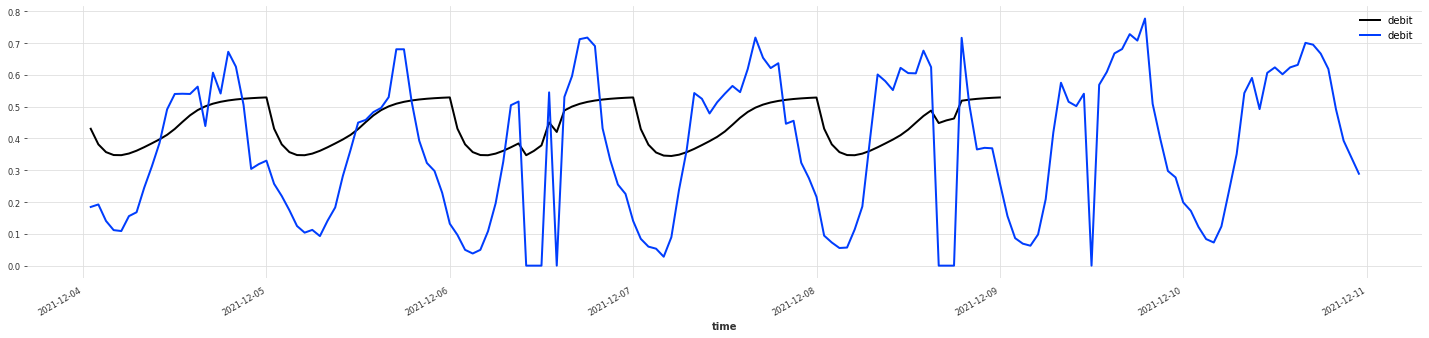

In [57]:
forecast_horizon = 24*5
past_covs = target_arc['past_covs_scaled'].univariate_component(0).append_values(np.ones(forecast_horizon))
future_covs = target_arc['past_covs_scaled'].univariate_component(1).append_values(np.zeros(forecast_horizon))

preds = my_model.predict(forecast_horizon, past_covariates=past_covs, future_covariates=future_covs)
preds.univariate_component(0).plot()
target_arc['val_scaled'].univariate_component(0).plot()

### fit multiple timeseries

In [53]:
all_arcs[0].keys()

dict_keys(['noeud_amont', 'noeud_aval', 'ts', 'targets', 'train_scaled', 'val_scaled', 'targets_scaled', 'past_covs', 'past_covs_scaled'])

In [54]:
# my_model.fit([target_arc['train_scaled'][-200:]]*2,
#              past_covariates=[target_arc['past_covs_scaled'].univariate_component(0)[-2000:]]*2,
#              future_covariates=[target_arc['past_covs_scaled'].univariate_component(1)[-2000:]]*2,
#              verbose=True)
my_model.fit([arc['train_scaled'][-200:] for arc in all_arcs],
             past_covariates=[arc['past_covs_scaled'].univariate_component(0)[-2000:] for arc in all_arcs],
             future_covariates=[arc['past_covs_scaled'].univariate_component(1)[-2000:] for arc in all_arcs],
             verbose=True)

  0%|          | 0/1 [00:00<?, ?it/s]

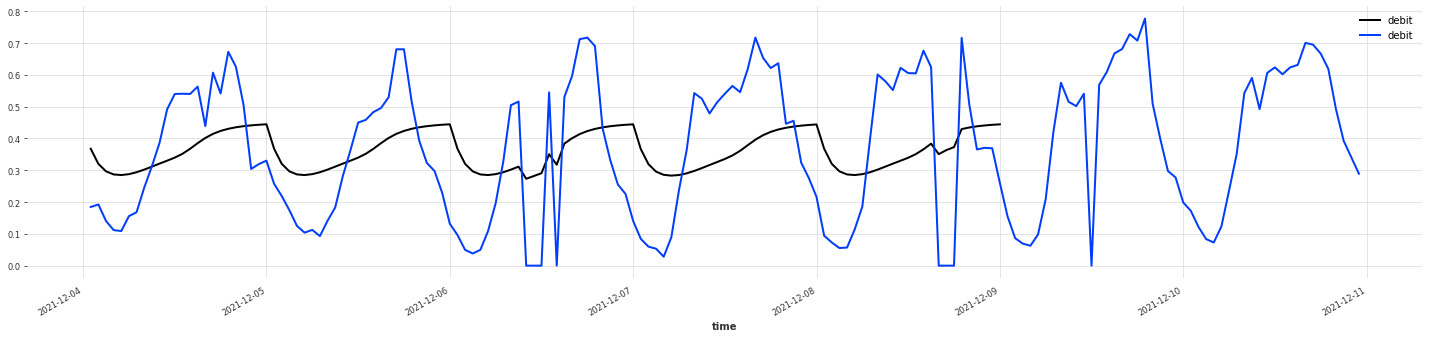

In [55]:
forecast_horizon = 24*5
past_covs = target_arc['past_covs_scaled'].univariate_component(0).append_values(np.ones(forecast_horizon))
future_covs = target_arc['past_covs_scaled'].univariate_component(1).append_values(np.zeros(forecast_horizon))

# NOTE: fitting on multiple series gives the "need past_covariates" error
# to avoid that, we fit on a single series one last time and then predict using only future_covariates
preds = my_model.predict(forecast_horizon, past_covariates=past_covs, future_covariates=future_covs)
preds.univariate_component(0).plot()
target_arc['val_scaled'].univariate_component(0).plot()